### Try it 10.1: Decomposing Time Series


<center>
    <img src = './images/spots.png' /><img src = './images/air.png' />
</center>


 

This activity fouses on exploring two different time series and the decomposed elements.  The example of sunspots data is given as well as a dataset containing air passenger information through the twentieth century in the United States.  These are both time series datasets however there is a distinct difference in the nature of the time series.  

Below, you are to use the statsmodels function `seasonal_decompose` to show how the trend and seasonality of the series differ in (perhaps) expected ways.  To begin, you are to make sure the datasets contain an appropriate time stamp index -- statsmodels expects this.  Then, use the `seasonal_decompose` function to decompose the series into trend and seasonality.  Examing plots of these elements, and discuss the similarities and differences between these components for the two time series.  

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Sunspots

## Data Load

In [3]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [4]:
sunspots["YEAR"] = pd.to_datetime(sunspots["YEAR"], format="%Y")
sunspots = sunspots.set_index("YEAR")
sunspots.head()

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


In [5]:
y_sunspots = sunspots.loc["1900":"2000", "SUNACTIVITY"].copy(deep=True)

## Work to Get Period and Filter Design

### Time Select

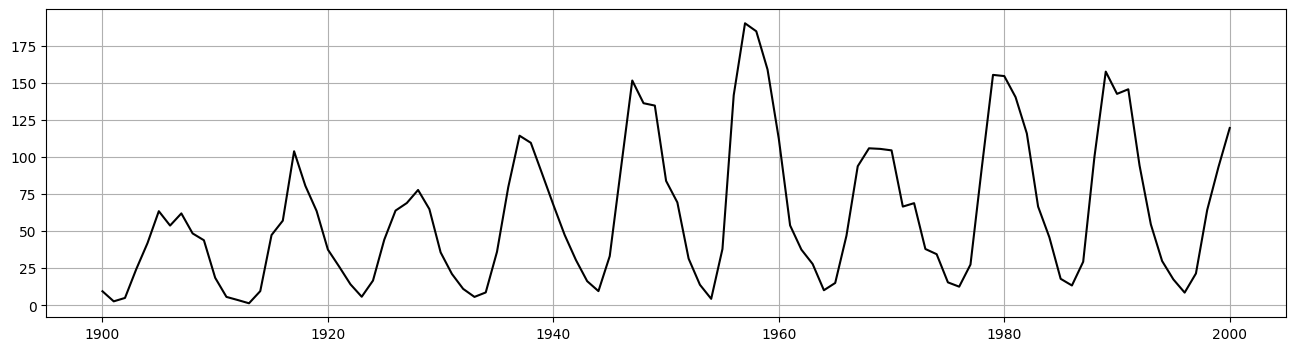

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(y_sunspots, color="black", label="Sunspots")
plt.show()

### Guess at Period of Data

From above looks like about 12 year periods

In [7]:
period_guess = 12
lows = []
next_low_guess = 0
search_width = 5

while next_low_guess <= len(y_sunspots):
    low_best = next_low_guess
    min_val = np.inf

    for kw in range(-search_width, search_width + 1):
        kidx = next_low_guess + kw
        if kidx < len(y_sunspots):
            this_val = y_sunspots[kidx]
            if this_val < min_val:
                min_val = this_val
                low_best = kidx

    lows.append(low_best)
    next_low_guess = low_best + period_guess
    print(
        "Added low at index %03d with value %5.2f, next guess = %03d"
        % (low_best, min_val, next_low_guess)
    )

sunspots_avg_period = int(np.round(np.mean(np.diff(np.array(lows)))))
print("\nList of period ends = %s, Average Period = %d" % (lows, sunspots_avg_period))

Added low at index 001 with value  2.70, next guess = 013
Added low at index 013 with value  1.40, next guess = 025
Added low at index 023 with value  5.80, next guess = 035
Added low at index 033 with value  5.70, next guess = 045
Added low at index 044 with value  9.60, next guess = 056
Added low at index 054 with value  4.40, next guess = 066
Added low at index 064 with value 10.20, next guess = 076
Added low at index 076 with value 12.60, next guess = 088
Added low at index 086 with value 13.40, next guess = 098
Added low at index 096 with value  8.60, next guess = 108

List of period ends = [1, 13, 23, 33, 44, 54, 64, 76, 86, 96], Average Period = 11


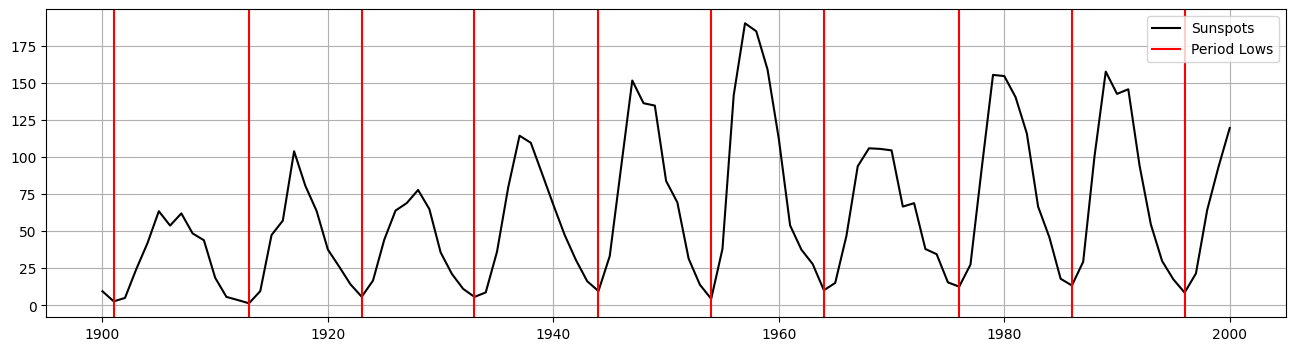

In [8]:
plt.figure(figsize=(16, 4))
plt.plot(y_sunspots, color="black", label="Sunspots")
for low in lows:
    if low < len(y_sunspots):
        plt.axvline(
            x=y_sunspots.index[low],
            color="red",
            label="Period Lows" if low == lows[0] else None,
        )
plt.legend()
plt.show()

In [9]:
sunspots_filt = np.ones(sunspots_avg_period + 1)
sunspots_filt[0] = 0.5
sunspots_filt[-1] = 0.5
sunspots_filt /= sunspots_avg_period
sunspots_filt

array([0.04545455, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.04545455])

In [10]:
sunspots_trend = _extrapolate_trend(
    convolution_filter(y_sunspots, sunspots_filt), len(sunspots_filt)
)

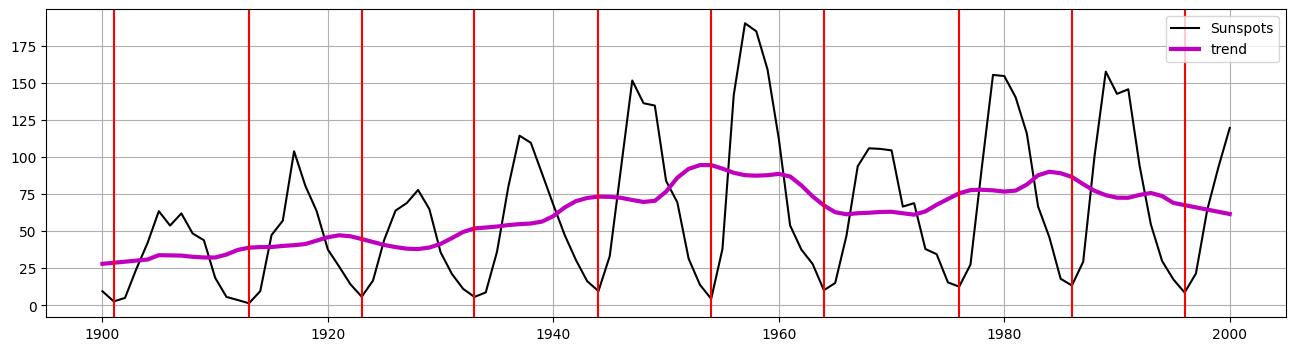

In [11]:
plt.figure(figsize=(16, 4))
plt.plot(y_sunspots, "k", label="Sunspots")
plt.plot(sunspots_trend, "m", linewidth=3, label="trend")
plt.legend()
for low in lows:
    if low < len(y_sunspots):
        plt.axvline(x=y_sunspots.index[low], color="red", label="lows")
# plt.legend()
plt.show()

In [12]:
sunspots_detrended = (y_sunspots - sunspots_trend).to_numpy()

## Seasonal Decompose

Using results from above

In [13]:
y_sunspots = sunspots["SUNACTIVITY"].copy(deep=True)

In [14]:
sunspots_decomposed = seasonal_decompose(
    y_sunspots.copy(deep=True),
    model="additive",
    period=sunspots_avg_period,
    extrapolate_trend=sunspots_avg_period,
)

display(np.sqrt((sunspots_decomposed.resid**2).mean()))

29.39159091410323

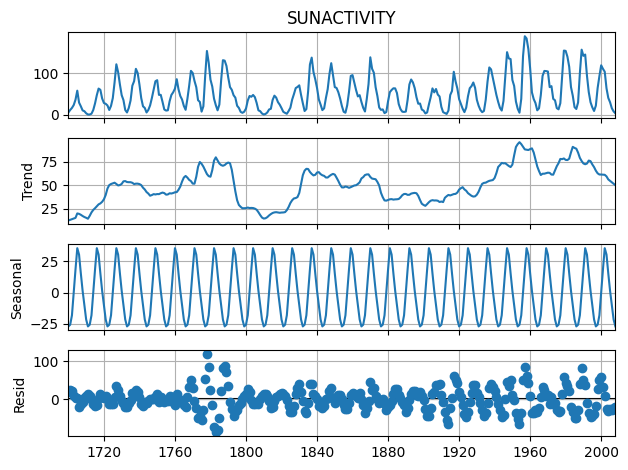

In [15]:
sunspots_decomposed.plot()
plt.show()

In [16]:
y_sunspots_modeled = sunspots_decomposed.trend + sunspots_decomposed.seasonal

In [17]:
sunspots_mae = np.abs(sunspots_decomposed.resid).mean()
sunspots_rmse = np.sqrt((sunspots_decomposed.resid**2).mean())
[sunspots_mae, sunspots_rmse]

[22.44037365821329, 29.39159091410323]

In [30]:
# Also make a model using period = 10 years
sunspots_avg_period_10 = 10
sunspots_decomposed_period_10 = seasonal_decompose(
    y_sunspots.copy(deep=True),
    model="additive",
    period=sunspots_avg_period_10,
    extrapolate_trend=sunspots_avg_period_10,
)

y_sunspots_modeled_10 = (
    sunspots_decomposed_period_10.trend + sunspots_decomposed_period_10.seasonal
)

sunspots_mae_10 = np.abs(sunspots_decomposed_period_10.resid).mean()
sunspots_rmse_10 = np.sqrt((sunspots_decomposed_period_10.resid**2).mean())
[sunspots_mae_10, sunspots_rmse_10]

[24.059506678909354, 29.548629876840778]

## Final Plot

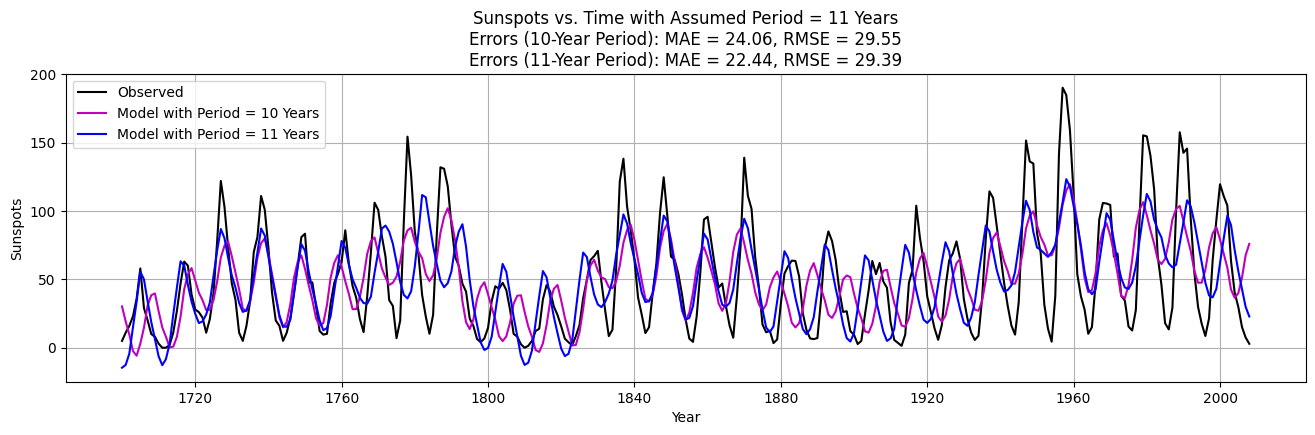

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(y_sunspots, color="black", label="Observed")
plt.plot(y_sunspots_modeled_10, color="m", label="Model with Period = 10 Years")
plt.plot(y_sunspots_modeled, color="blue", label="Model with Period = 11 Years")
plt.title(
    "Sunspots vs. Time with Assumed Period = %d Years\nErrors (10-Year Period): MAE = %.2f, RMSE = %.2f\nErrors (11-Year Period): MAE = %.2f, RMSE = %.2f"
    % (
        sunspots_avg_period,
        sunspots_mae_10,
        sunspots_rmse_10,
        sunspots_mae,
        sunspots_rmse,
    )
)
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.legend(loc="upper left")

plt.show()

# Air Travel

## Data Load

In [20]:
air = pd.read_csv("./data/AirPassengers.csv")
air.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [21]:
air["Month"] = pd.to_datetime(air["Month"], format="%Y-%m")
air = air.set_index("Month")
air.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [22]:
y_air = air["#Passengers"].copy(deep=True)

<Axes: xlabel='Month'>

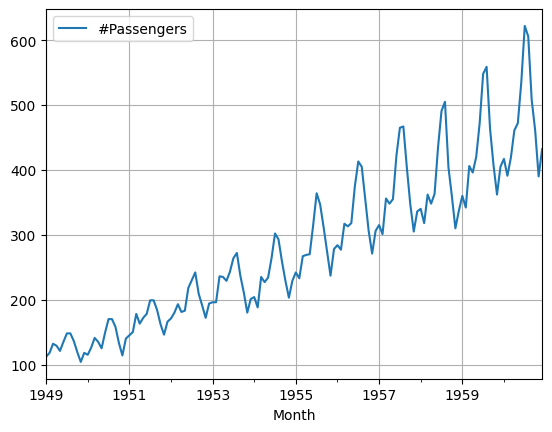

In [23]:
air.plot()

## Seasonal Decompose

In [24]:
air_period_months = 12
air_decomposed = seasonal_decompose(
    y_air.copy(deep=True),
    model="multiplicative",
    period=air_period_months,
    extrapolate_trend=air_period_months,
)

display(np.sqrt((air_decomposed.resid**2).mean()))

1.001147662173925

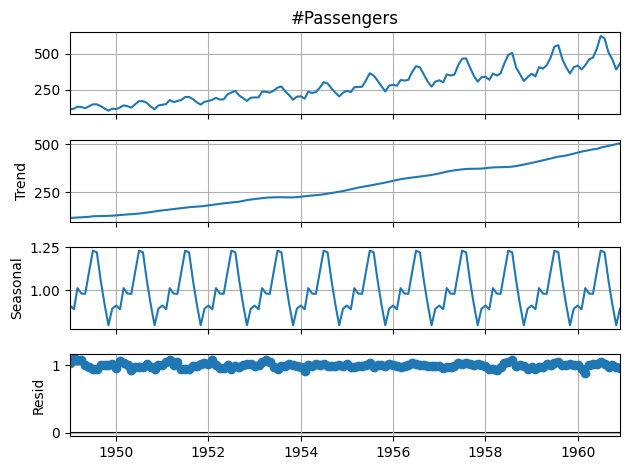

In [25]:
air_decomposed.plot()
plt.show()

In [26]:
y_air_modeled = air_decomposed.trend * air_decomposed.seasonal

In [27]:
air_mae = np.abs(air_decomposed.resid).mean()
air_rmse = np.sqrt((air_decomposed.resid**2).mean())
[air_mae, air_rmse]

[1.0005187836753948, 1.001147662173925]

## Final Plot

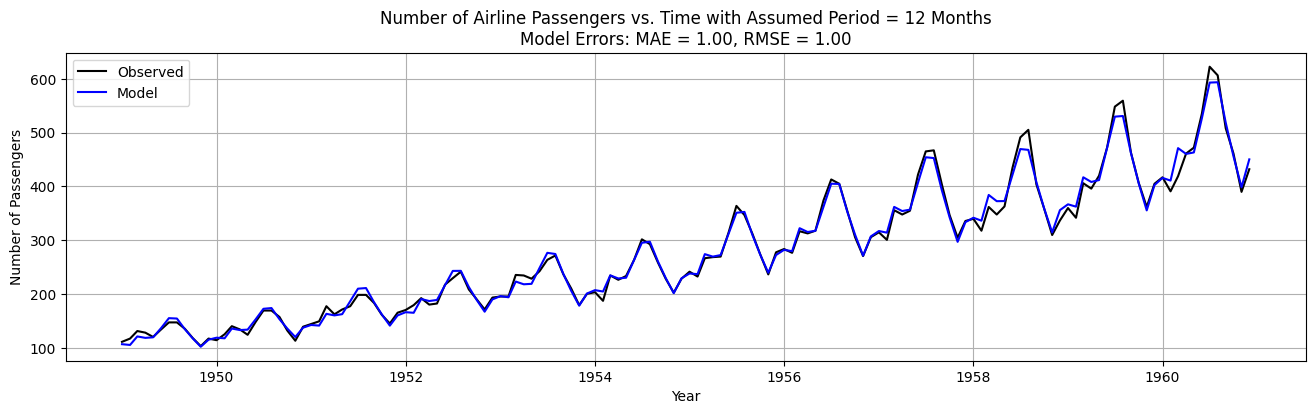

In [28]:
plt.figure(figsize=(16, 4))
plt.plot(y_air, color="black", label="Observed")
plt.plot(y_air_modeled, color="blue", label="Model")
plt.title(
    "Number of Airline Passengers vs. Time with Assumed Period = %d Months\nModel Errors: MAE = %.2f, RMSE = %.2f"
    % (air_period_months, air_mae, air_rmse)
)
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend(loc="upper left")
plt.show()